<a href="https://colab.research.google.com/github/bharatadhik/jupyternotebooks/blob/main/TB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi 

Sun Feb  6 11:32:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import  Conv2D,Dense,Flatten,MaxPool2D,Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import  BatchNormalization


In [59]:
from tensorflow.keras.models            import Sequential
from tensorflow.keras.layers            import Conv2D,MaxPooling2D,Dense,Flatten

from tensorflow.keras.optimizers        import SGD
from tensorflow.keras.optimizers        import Adam

In [60]:
#image augmentation
train_datagenerator = image.ImageDataGenerator(
    rescale = 1.0/255.0, #data normalization
    shear_range = 0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip =True
)
# visualize_train = image.ImageDataGenerator(
#     rescale = 1.0/255.0
# )
# visualize_generator = visualize_train.flow_from_directory(
#     '/content/drive/MyDrive/TB_Datasets_new/train',
#     target_size=(224,224)
# )


val_datagenerator = image.ImageDataGenerator(
    rescale =  1.0/255.0)

# Create an actual train generator function
train_generator = train_datagenerator.flow_from_directory(
    '/content/drive/MyDrive/TB_Datasets_new/train',
    target_size = (256,256),
    batch_size=32,
    class_mode = 'binary',color_mode="grayscale")

# Create an actual validation generator function
validation_generator = val_datagenerator.flow_from_directory(
    '/content/drive/MyDrive/TB_Datasets_new/val',
    target_size = (256,256),
    batch_size=32,
    class_mode = 'binary', color_mode="grayscale")

Found 3148 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [61]:
!pip install collection
# Examine the class label imbalance
# Get the counts for each class

from collections import Counter
cases_count = Counter (train_generator.classes)
print(cases_count.items())

dict_items([(0, 2625), (1, 523)])


In [62]:
total = cases_count[0]+cases_count[1]
weight_for_0 = (1 / cases_count[0] ) * (total/2.0)
weight_for_1 = (1/cases_count[1]) * (total /2.0)
class_weight = { 0: weight_for_0, 1:weight_for_1}
print(class_weight)

{0: 0.5996190476190476, 1: 3.0095602294455066}


In [63]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(256, 256,1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu',  padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu',  padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu',  padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
# compile model
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [148]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      9248      
                                                      

In [64]:
#saving model during highest val_accuracy
model_save_path = '/content/drive/MyDrive/cnn_model.h5'
checkpoint = ModelCheckpoint(filepath=model_save_path,monitor= 'val_accuracy',verbose = 1,save_best_only = True,mode = 'max')
callbacks_list = [checkpoint]

In [66]:
history = model.fit(train_generator,
                        epochs = 20,
                        verbose = 1,
                        validation_data = validation_generator,
                        callbacks = callbacks_list,
                        class_weight=class_weight)

Epoch 1/20
99/99 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.7938
Epoch 00001: val_accuracy improved from -inf to 0.89762, saving model to /content/drive/MyDrive/cnn_model.h5
99/99 [==============================] - 105s 1s/step - loss: 0.4900 - accuracy: 0.7938 - val_loss: 0.4707 - val_accuracy: 0.8976
Epoch 2/20
99/99 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8650
Epoch 00002: val_accuracy did not improve from 0.89762
99/99 [==============================] - 77s 771ms/step - loss: 0.3996 - accuracy: 0.8650 - val_loss: 0.3702 - val_accuracy: 0.8798
Epoch 3/20
99/99 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8752
Epoch 00003: val_accuracy did not improve from 0.89762
99/99 [==============================] - 77s 774ms/step - loss: 0.3296 - accuracy: 0.8752 - val_loss: 0.2786 - val_accuracy: 0.8821
Epoch 4/20
99/99 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8764
Epoch 00004

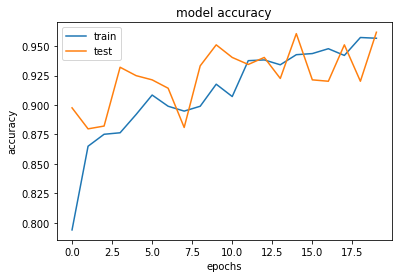

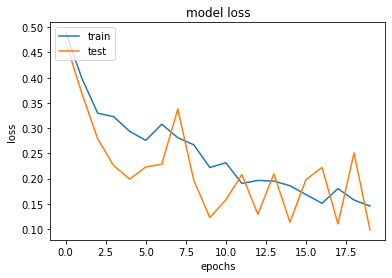

In [67]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc = 'upper left')
plt.show()


In [68]:
test_generator = val_datagenerator.flow_from_directory(
    '/content/drive/MyDrive/TB_Datasets_new/test',
    target_size = (256,256),
    batch_size=32,
    class_mode = 'binary', color_mode="grayscale")

Found 210 images belonging to 2 classes.


In [69]:

loss_score,accu = model.evaluate(test_generator)

# score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss_score)
print('Test accuracy:', accu)

7/7 [==============================] - 3s 392ms/step - loss: 0.0707 - accuracy: 0.9762
Test loss: 0.07065983861684799
Test accuracy: 0.976190447807312


In [70]:
# import cv2
# test_it = datagen.flow_from_directory('D:\\DOWNLOADS\\TB_datasets\\TB_Chest_Radiography_Database\\TB_Datasets_new\\test', class_mode='binary', batch_size=64)

In [71]:
# import os
# # load all images into a list
# images = []
# for img in os.listdir(pathss):
#     imgpath = os.path.join(pathss, img)
#     img1 = cv2.imread(imgpath)
#     # print(imgpath)
   
#     img1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
#     img1 = cv2.resize(img1, (256,256))
#     # print(img1.shape)
#     plt.imshow(img1,cmap='gray')
 
#     Y = image.img_to_array(img1)
  
    
#     X = np.expand_dims(Y,axis=0)

#     images.append(X)

# # stack up images list to pass for prediction
# images = np.vstack(images)
# classes = model.predict(images, batch_size=10)
# print(classes)

# Threshold valuse changing from 0.5 >0.4

# Threold changing is important step. Discuss with doctors for threshold values ✅✅✅ 

In [72]:
import os
import cv2
labels = ['Normal', 'Tuberculosis']
img_size = 256
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [85]:
test = get_training_data('/content/drive/MyDrive/TB_Datasets_new/test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [86]:
x_test = []
y_test = []
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
x_test = np.array(x_test) / 255.0
x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)
print(x_test.shape)

(210, 256, 256, 1)


In [87]:
predicted = model.predict(np.array(x_test))

In [88]:
# best model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/cnn_model.h5')

In [89]:
model.evaluate(x_test,np.array(y_test))

7/7 [==============================] - 1s 152ms/step - loss: 0.0681 - accuracy: 0.9762


[0.06814443320035934, 0.976190447807312]

In [ ]:
predicted

In [91]:
result = []
for item in predicted:
    result.append(np.argmax(item))

In [92]:
print(result)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


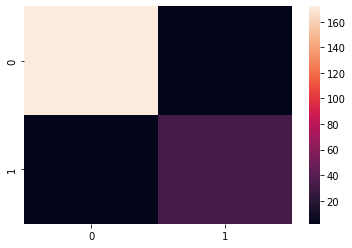

In [93]:
sns.heatmap(confusion_matrix(result,y_test))


In [94]:
cm = confusion_matrix(y_test,result)
cm

array([[172,   3],
       [  2,  33]])

In [95]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])


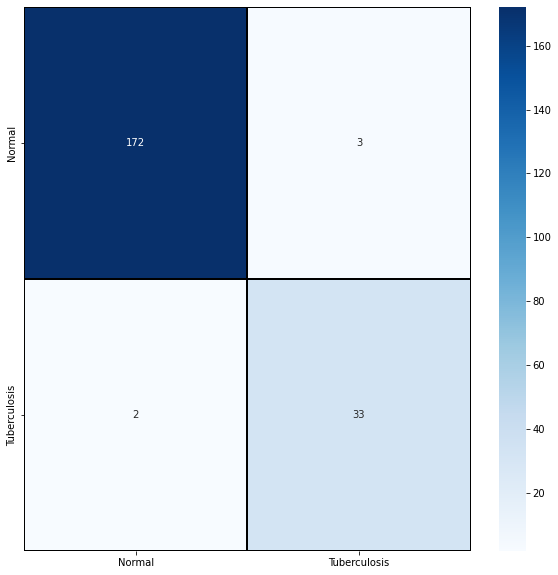

In [96]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

# Saliency map ✅

In [155]:
# from tensorflow.keras.preprocessing.image import load_img
import cv2
img1 = cv2.imread('/content/drive/MyDrive/TB_Datasets_new/test/Tuberculosis/Tuberculosis-103.png')
img2 = cv2.imread('/content/drive/MyDrive/TB_Datasets_new/test/Tuberculosis/Tuberculosis-114.png',cv2.IMREAD_GRAYSCALE)

img3 = cv2.imread('/content/drive/MyDrive/TB_Datasets_new/test/Tuberculosis/Tuberculosis-119.png',cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('/content/drive/MyDrive/TB_Datasets_new/test/Tuberculosis/Tuberculosis-138.png',cv2.IMREAD_GRAYSCALE)

print(img1.shape)
img1 = cv2.resize(img1, (256,256))
img2 = cv2.resize(img2, (256,256))
img3 = cv2.resize(img3, (256,256))
img4 = cv2.resize(img4, (256,256))
print(img1.shape)

(512, 512, 3)
(256, 256, 3)


In [113]:
#create array of images

images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])


In [114]:
#utility function to show images
def display_imgs(images):
  subprot_args = {
   'nrows': 1,
   'ncols': 4,
   'figsize': (6, 3),
   'subplot_kw': {'xticks': [], 'yticks': []}
  }
  f, ax = plt.subplots(**subprot_args)
  for i in range(len(images)):
    ax[i].imshow(images[i])
  plt.tight_layout()
  plt.show()

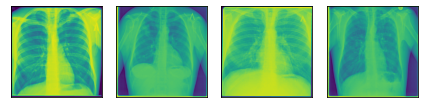

In [115]:
#show images
display_imgs(images)

In [119]:
from tensorflow.keras.utils import img_to_array
#convert to numpy array for reshaping
# img1 = img_to_array(img1)
# img2 = img_to_array(img2)
# img3 = img_to_array(img3)
# img4 = img_to_array(img4)

#reshape to prepare for processing
img1 = img1.reshape(1,256,256,1)
img2 = img2.reshape(1,256,256,1)
img3 = img3.reshape(1,256,256,1)
img4 = img4.reshape(1,256,256,1)
print(img1.shape)

(1, 256, 256, 1)


In [145]:
# predictions with input images
yhat1 = model.predict(img1)
yhat2 = model.predict(img2)
yhat3 = model.predict(img3)
yhat4 = model.predict(img4)
from tf_keras_vis.utils.scores import CategoricalScore

#cat - 281, dog -235 , hen -8, tiger - 292
scores = CategoricalScore([1,1,1,1])
print(scores)

NameError: ignored

In [ ]:
# input_images = images
# !pip install tf-keras-vis 
# from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# #Create Saliency object
# saliency = Saliency(model, clone=False)

# # Generate saliency map
# saliency_map = saliency(scores, input_images)
# saliency_map = normalize(saliency_map)

# subprot_args = {
#    'nrows': 1,
#    'ncols': 4,
#    'figsize': (6, 3),
#    'subplot_kw': {'xticks': [], 'yticks': []}
# }


In [168]:
# The last convolutional layer in VGG19 is called 'block5_conv4 in Keras'
last_conv_layer = model.get_layer('conv2d_21')
num_classes=len([0,1])
max_imgs = np.empty([num_classes, 256,256, 1])

In [169]:
from tensorflow.python.keras import backend as K
def generate_saliency(img, class_pred, model):
    '''
    Generates the Saliency map of img with respect to class_pred, given the Keras model.
    '''
    inp = model.input
    class_outp = model.output[:, class_pred]
    sal = K.gradients(tf.reduce_sum(class_outp), inp)[0]
    # Keras function returning the saliency map given an image input
    sal_fn = K.function([inp], [sal])
    # Generating the saliency map and normalizing it
    img_sal = sal_fn([np.resize(img, (1,256,256,1))])[0]
    img_sal = np.abs(img_sal)
    img_sal /= img_sal.max()
    return img_sal

RecursionError: ignored

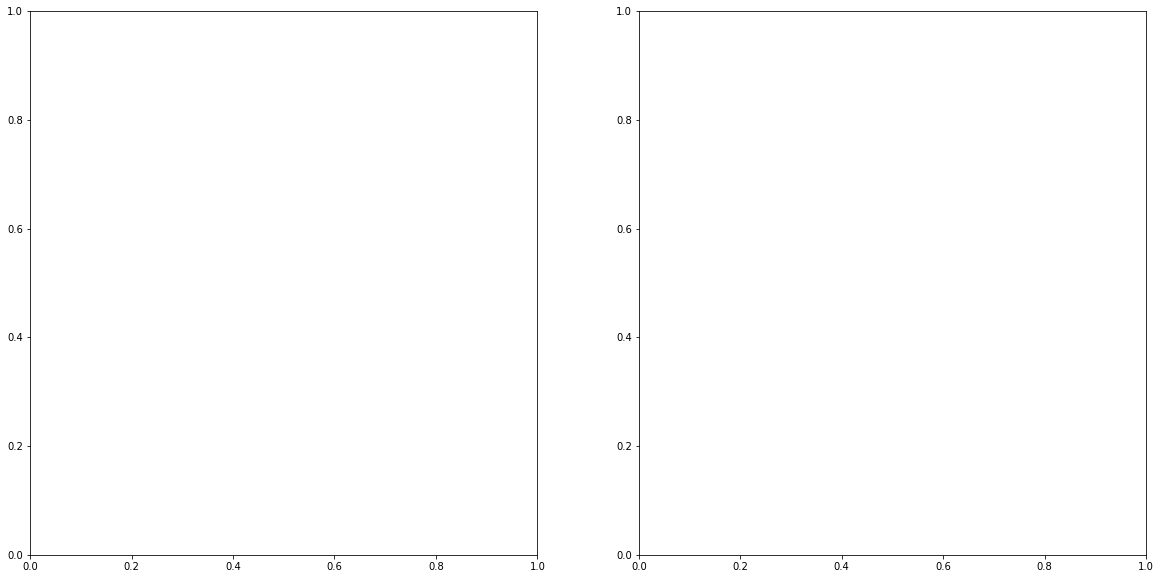

In [174]:
tf.compat.v1.disable_eager_execution()
fig, ax = plt.subplots(1, num_classes, figsize=(20,10))
saliency = generate_saliency(img1, 1, model)
ax.imshow(saliency[0,...,0], cmap='jet')
ax.set_title('TB'+' Saliency', fontsize=15)

(1, 256, 256, 1)
(1, 256, 256, 1)


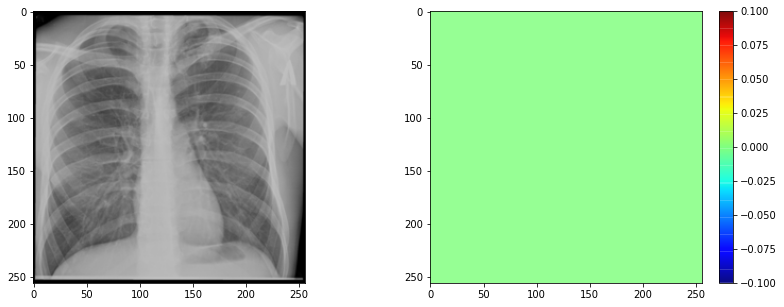

In [167]:
import cv2
import numpy as np
# another saliency
#preprocess image to get it into the right format for the model
img = np.array(img1,np.uint8)
img2 = img
img= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img = img.reshape((1, *img.shape))
img= img.reshape(1,256,256,1)
print(img.shape)

print(img.shape)
y_pred = model.predict(img)

layers = [layer.output for layer in model.layers]

images = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(img2)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)